In [1]:
# import libraries
import os
import pandas as pd
import numpy as np

import glob
import ast
import datetime

from scipy import signal

import matplotlib.colors as colors


import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../dependencies/')

from plotting import *



In [2]:
assetId = ['IMS2_Bearing1','IMS2_Bearing2','IMS2_Bearing3','IMS2_Bearing4']
sensorId = ['sensor1','sensor1','sensor1','sensor1']

Set No. 2:
Recording Duration: February 12, 2004 10:32:39 to February 19, 2004 06:22:39

No. of Files:984

No. of Channels: 4

Channel Arrangement: 

Bearing 1 –Ch 1; 
Bearing2 –Ch 2; 
Bearing3 –Ch3; 
Bearing 4 –Ch 4.

File Recording Interval: Every 10 minutes
File Format: ASCII
Description: At  the  end  of  the  test-to-failure  experiment,  outer  race  failure  occurred  in bearing 1.

AssetId = Bearing1-Set1
SensorId = Channel1

In [6]:
# load, average and merge sensor samples
data_dir = '../../Data/IMS/2nd_test/'


In [7]:
fileNames = os.listdir(data_dir)
files = [f for f in glob.glob(data_dir + '/2004*', recursive=True)]


samplingRate = int(20e3)
fftPoints = 2048

bearing1FFT = np.empty((len(files),1025))
bearing2FFT = np.empty((len(files),1025))
bearing3FFT = np.empty((len(files),1025))
bearing4FFT = np.empty((len(files),1025))
datetime_strings = []

columns = ['Date']
columns += ['FFT-' + str(i) for i in range(bearing1FFT.shape[1])]

In [8]:
def parse_file(filename,index=0):
    global bearing1FFT
    global bearing2FFT
    global bearing3FFT
    global bearing4FFT

    dataset = pd.read_csv(filename, sep='\t')
    
    data = dataset.values
    
    datetime_object = datetime.datetime.strptime(filename.split('/')[-1], '%Y.%m.%d.%H.%M.%S')
    datetime_string = datetime_object.strftime('%Y-%m-%d %H:%M:%S.%f')
    
    datetime_strings.append(datetime_string)
 
    freqs,amps = signal.welch(data.T, fs=samplingRate, window='hanning', nperseg=fftPoints)
    

    bearing1FFT[index,:] = amps[0,:]
    bearing2FFT[index,:] = amps[1,:]
    bearing3FFT[index,:] = amps[2,:]
    bearing4FFT[index,:] = amps[3,:]
    
    
    return freqs


In [9]:

for j in range(len(files)):
    freqs = parse_file(files[j],j)
    

In [10]:
timeDF = pd.DataFrame(np.array(datetime_strings))
timeDF.to_csv('bearingFFT_datetime.csv')
times = pd.to_datetime(timeDF.values[:,0]).values

ts = (times - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

times = [datetime.date.fromtimestamp(ts[i]) for i in range(len(ts))]

fft1Data = np.hstack((np.array(times)[...,np.newaxis],bearing1FFT))
fft1DF = pd.DataFrame(data=fft1Data,columns=columns)
fft1DF['Date'] = pd.to_datetime(fft1DF.Date)
fft1DF = fft1DF.sort_values(by='Date')
bearing1FFT = fft1DF.values[:,1:]
times = fft1DF.values[:,0]
time_deltas = plotting.timedelta_helper(times,'days')


/home/dnewman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """


In [8]:
def plot_spectrogram(
            time,
            spectrogram,
            frequencyInterval,
            size=(12,4),
            showplot = False,
            save_plot = False,
            transparent = False,
            folder = None,
            filename = 'Spectrogram',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='pdf',
            date_format='%I:00 %p, %b %d',
            xlabel = 'Time'
            ):

    yi = np.arange(-0.0, spectrogram.shape[0] * frequencyInterval,frequencyInterval)
    xi = np.linspace(0.0,1,spectrogram.shape[1]) * np.amax(time)

    X, Y = np.meshgrid(xi, yi)
    plt.figure(figsize=size)
    
    print(X.shape)
    print(Y.shape)
    print(spectrogram.shape)

    # Customize the axes
    ax = plt.gca()
    plt.pcolormesh(X,Y,spectrogram,cmap='cividis',norm=colors.LogNorm(vmin=np.amin(spectrogram),vmax=np.amax(spectrogram)))

    ax.tick_params(labelsize=18)

    cbar = plt.colorbar()
    cbar.set_label(r'\textbf{PSD ($V^2 / Hz$)}', rotation=270,labelpad=20)
    plt.ylabel(r'\textbf{Frequency (Hz)}', labelpad=ylabelpad,fontsize=22)
    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad,fontsize=22)

    plt.tight_layout(pad=1.2)

    if save_plot:
        if folder is not None:
            # Ensure that the folder we want to save to exists
            if not os.path.exists(folder):
                os.makedirs(folder)

            filename = folder + '/' + filename

        # Save the pdf of the plot    
        if file_type == 'png':
            plt.savefig('{}.png'\
                    .format(filename),transparent=transparent)             
        elif file_type == 'pdf':
            plt.savefig('{}.pdf'\
                    .format(filename))    
        elif file_type == 'svg':
            plt.savefig('{}.svg'\
                    .format(filename)) 

    if showplot:
        plt.show()

    # Clear the axes and figure
    plt.clf()
    plt.cla()
    plt.close()

In [9]:
spectrogram = bearing1FFT.astype(float).T
frequencyInterval = freqs[1]

(1025, 984)
(1025, 984)
(1025, 984)


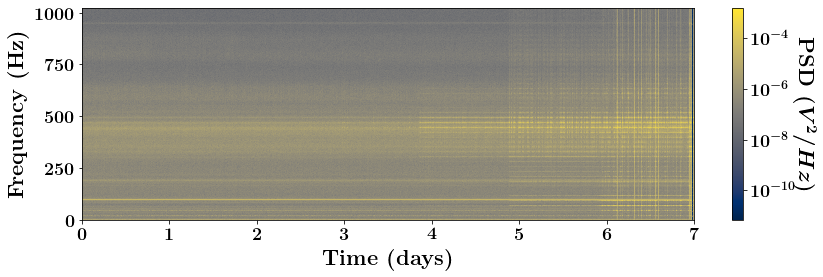

In [10]:
plot_spectrogram(
            time_deltas,
            bearing1FFT.astype(float).T,
            1,
            size=(12,4),
            showplot = True,
            save_plot = True,
            transparent = True,
            folder = 'figures/IMS2_Spectrogram/',
            filename = 'Bearing1_Spectrogram',
            xlabelpad = 5,    
            ylabelpad = 5,   
            file_type='png',
            date_format='%I:00 %p, %b %d',
            xlabel='Time (days)'
            )